### Launch spark environment

In [18]:
spark

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 21, Finished, Available)

In [2]:
%%configure -f \
{"conf": {"spark.jars.packages": "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.2"}}

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, -1, Finished, Available)

Unrecognized options: 

In [3]:
!pip install spark-nlp

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 6, Finished, Available)

     |████████████████████████████████| 540 kB 9.0 MB/s eta 0:00:01


In [4]:
# read the data
workspace_default_storage_account = "group08astoragec0a5c9b39"
workspace_default_container = "azureml-blobstore-8f67895d-e507-48c5-8b8e-f003f0227b44"

workspace_wasbs_base_url = (
    f"wasbs://{workspace_default_container}@{workspace_default_storage_account}.blob.core.windows.net/"
)
df = spark.read.parquet((f"{workspace_wasbs_base_url}<PATH-TO-READ/WRITE>"))

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 7, Finished, Available)

In [5]:
from pyspark.sql.functions import when, col, regexp_extract
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 8, Finished, Available)

In this section, I will select all the Reddit comments related to World Cup 2022 and conduct sentiment analysis over time. First of all, I will use several key words to define the regex pattern and select all the relevant posts regarding World Cup 2022. Then, three dummy variables will be created, which indicate whether a Reddit post is related to the champion, the players or the referees. After that, I will leverage a pre-trained sentiment analysis model to predict the sentiment category for each post. Eventually, several data visualizations will be created for displaying the sentiment by category and how it evolved over time.

## Filter the posts related to World Cup 2022

In [22]:
df_worldcup = df.filter(col('body').rlike('(?i)world cup|Qatar|fifa 2022|national|final'))

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 25, Finished, Available)

In [13]:
df_worldcup.cache

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 16, Finished, Available)

<bound method DataFrame.cache of DataFrame[author: string, author_flair_text: string, body: string, controversiality: bigint, created_utc: timestamp, gilded: bigint, score: bigint, stickied: boolean, subreddit: string]>

In [23]:
df_worldcup.count()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 26, Finished, Available)

157607

## Create three dummy variables about different sub-topics within World Cup

In [24]:
df_worldcup = df_worldcup.withColumn("champion", (col("body").rlike("(?i)champion|Argentina|3 star|three star|del mundo")).cast("int"))
df_worldcup = df_worldcup.withColumn("players", (col("body").rlike("(?i)player|Messi|Leo|Enzo|Alvarez|Di Maria|Lautaro|De Paul|Mac Allister|Romero|Mbappe|Ronaldo|Martinez|Neymar|Kylian|Lewandowski|vvd|Modric|Kane|van Dijk|Hazard|Suarez|Kevin|De Bruyne|Muller")).cast("int"))
df_worldcup = df_worldcup.withColumn("referee", (col("body").rlike("(?i)referee|penalty|red card|yellow card|Misjudgment|VAR|offside")).cast("int"))

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 27, Finished, Available)

In [26]:
df_worldcup.groupBy('champion').agg(F.count('*').alias('count')).show()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 29, Finished, Available)

+--------+------+
|champion| count|
+--------+------+
|       1| 11027|
|       0|146580|
+--------+------+



In [27]:
df_worldcup.groupBy('players').agg(F.count('*').alias('count')).show()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 30, Finished, Available)

+-------+------+
|players| count|
+-------+------+
|      1| 36087|
|      0|121520|
+-------+------+



In [28]:
df_worldcup.groupBy('referee').agg(F.count('*').alias('count')).show()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 31, Finished, Available)

+-------+------+
|referee| count|
+-------+------+
|      1|  6147|
|      0|151460|
+-------+------+



## Create a small data sample for code debugging

In [30]:
df_small = df_worldcup.sample(False, 0.01)
df_small.count()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 33, Finished, Available)

1609

In [31]:
df_small.show(5)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 34, Finished, Available)

+--------------------+--------------------+--------------------+----------------+-------------------+------+-----+--------+---------+--------+-------+-------+
|              author|   author_flair_text|                body|controversiality|        created_utc|gilded|score|stickied|subreddit|champion|players|referee|
+--------------------+--------------------+--------------------+----------------+-------------------+------+-----+--------+---------+--------+-------+-------+
|   Melloa_Trunk_Tree|                null|Finally,  Liverpo...|               0|2023-01-02 18:13:39|     0|    2|   false|   soccer|       0|      0|      0|
|              captdf|:Angel_City_FC: A...|WWC 2019 will hav...|               0|2023-01-26 23:42:55|     0|    2|   false|     NWSL|       0|      0|      1|
|       Cardealer1000|        :transpride:|No I'm genuinely ...|               0|2023-01-14 17:01:57|     0|    1|   false|   soccer|       0|      0|      1|
|            DickyD43|I don't give a fu...|The

## Utilize a pre-trained model and predict the sentiment category using piplines

In [9]:
documentAssembler = DocumentAssembler()\
    .setInputCol("body")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = SentimentDLModel.pretrained(name="sentimentdl_use_twitter", lang="en")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 12, Finished, Available)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


In [32]:
# Use the small dataset for sentiment analysis

content = df_small.select('body')
pipelineModel = nlpPipeline.fit(content)
result = pipelineModel.transform(content)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 35, Finished, Available)

In [33]:
result.show(5)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 36, Finished, Available)

+--------------------+--------------------+--------------------+--------------------+
|                body|            document| sentence_embeddings|           sentiment|
+--------------------+--------------------+--------------------+--------------------+
|Finally,  Liverpo...|[{document, 0, 44...|[{sentence_embedd...|[{category, 0, 44...|
|WWC 2019 will hav...|[{document, 0, 45...|[{sentence_embedd...|[{category, 0, 45...|
|No I'm genuinely ...|[{document, 0, 43...|[{sentence_embedd...|[{category, 0, 43...|
|Their UCL Finals ...|[{document, 0, 80...|[{sentence_embedd...|[{category, 0, 80...|
|Picky has always ...|[{document, 0, 53...|[{sentence_embedd...|[{category, 0, 53...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [38]:
senti = result.select('body', F.explode('sentiment.result'))

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 41, Finished, Available)

In [39]:
senti.show(5)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 42, Finished, Available)

+--------------------+--------+
|                body|     col|
+--------------------+--------+
|Finally,  Liverpo...|negative|
|WWC 2019 will hav...|positive|
|No I'm genuinely ...|positive|
|Their UCL Finals ...|positive|
|Picky has always ...|negative|
+--------------------+--------+
only showing top 5 rows



In [40]:
small_join = senti.join(df_small, on='body', how='inner')
small_join = small_join.select('col', 'created_utc', 'champion', 'players', 'referee')\
                .withColumnRenamed('col', 'sentiment')

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 43, Finished, Available)

In [41]:
small_join.show(5)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 44, Finished, Available)

+---------+-------------------+--------+-------+-------+
|sentiment|        created_utc|champion|players|referee|
+---------+-------------------+--------+-------+-------+
| negative|2023-01-02 18:13:39|       0|      0|      0|
| positive|2023-01-26 23:42:55|       0|      0|      1|
| positive|2023-01-14 17:01:57|       0|      0|      1|
| positive|2023-03-19 19:25:44|       0|      0|      0|
| negative|2023-01-14 16:46:07|       0|      0|      0|
+---------+-------------------+--------+-------+-------+
only showing top 5 rows



## Repeat the process on the real data

In [42]:
# Now repeat the process on the larger data

content = df_worldcup.select('body')
pipelineModel = nlpPipeline.fit(content)
result = pipelineModel.transform(content)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 45, Finished, Available)

In [43]:
senti = result.select('body', F.explode('sentiment.result'))

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 46, Finished, Available)

In [51]:
senti.count()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 54, Finished, Available)

157607

In [45]:
senti.show(5)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 48, Finished, Available)

+--------------------+--------+
|                body|     col|
+--------------------+--------+
|I mean, not reall...|negative|
|scored the cl fin...| neutral|
|The youth of toda...|positive|
|Ah fair, I'm supp...|negative|
|Beckenbauer playe...|positive|
+--------------------+--------+
only showing top 5 rows



In [53]:
senti.groupBy('body').count().orderBy(col('count').desc()).show(10)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 56, Finished, Available)

+--------------------+-----+
|                body|count|
+--------------------+-----+
|Today I feel Qata...|  936|
|Hello! Thanks for...|  444|
|             Finally|  171|
|Hello! Thanks for...|  165|
|Jinx? We are feck...|  128|
|             FINALLY|   66|
|     Fucking finally|   57|
|Please have a loo...|   53|
|Your post has bee...|   49|
|            Finally!|   41|
+--------------------+-----+
only showing top 10 rows



In [55]:
# Join the dataframes
df1_with_index = senti.select('col').withColumn("row_index", F.monotonically_increasing_id())
df2_with_index = df_worldcup.withColumn("row_index", F.monotonically_increasing_id())
df_join = df2_with_index.join(df1_with_index, "row_index")
df_join = df_join.drop("row_index")

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 58, Finished, Available)

In [59]:
df_join = df_join.select('col', 'created_utc', 'champion', 'players', 'referee')\
                .withColumnRenamed('col', 'sentiment')

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 62, Finished, Available)

In [56]:
df_join.count()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 59, Finished, Available)

157607

## Convert to a pandas dataframe

In [75]:
df_pd = df_join.toPandas()

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 78, Finished, Available)

In [67]:
datapath = 'Users/wc777/fall-2023-reddit-project-team-08/data'

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 70, Finished, Available)

In [61]:
df_pd.head(10)

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 64, Finished, Available)

,sentiment,created_utc,champion,players,referee
0,positive,2023-01-27 21:08:10,1,0,0
1,negative,2023-01-27 21:12:32,0,0,0
2,positive,2023-01-15 13:16:40,0,0,0
3,positive,2023-03-12 15:42:34,1,0,0
4,negative,2023-01-15 17:32:26,0,0,0
5,positive,2023-01-25 11:13:24,0,0,1
6,negative,2023-02-04 17:45:51,0,0,0
7,negative,2023-03-05 18:52:51,0,0,0
8,negative,2023-02-14 22:25:51,0,1,0
9,positive,2023-02-26 16:54:25,0,1,0


In [65]:
df_pd.dtypes

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 68, Finished, Available)

sentiment                  object
created_utc        datetime64[ns]
champion                    int32
players                     int32
referee                     int32
sentiment_score             int64
dtype: object

## Create a grouped barplot to display the sentiment result for each sub-topic

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 128, Finished, Available)

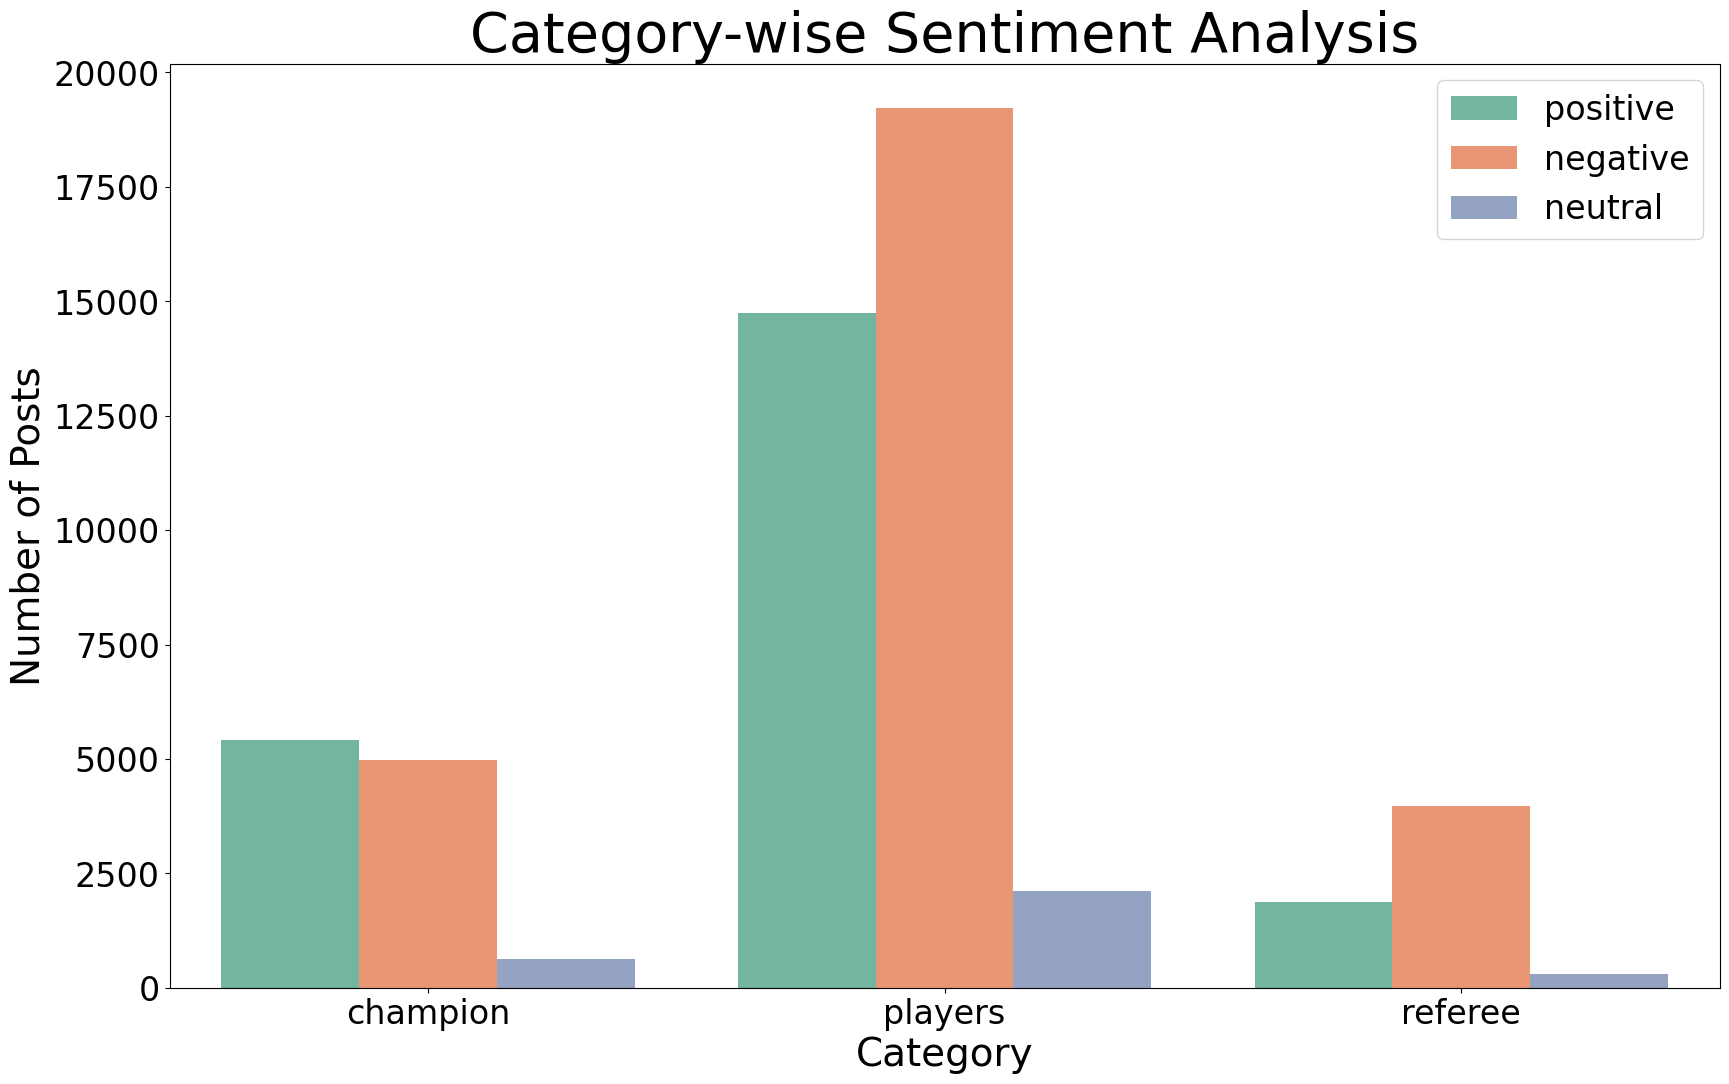

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pandas.tseries.offsets import Week
sns.reset_defaults()
plt.rcdefaults()

# Melt the dataset to make categories as a single column
melted_df = df_pd.melt(id_vars=['sentiment'], value_vars=['champion', 'players', 'referee'], var_name='category', value_name='mentioned')
melted_df = melted_df[melted_df['mentioned'] == 1]

# Plot category-wise sentiment analysis
plt.figure(figsize=(20, 12))
sns.countplot(data=melted_df, x='category', hue='sentiment', palette='Set2')
plt.title('Category-wise Sentiment Analysis', fontsize=40)
plt.ylabel('Number of Posts', fontsize=28)
plt.xlabel('Category', fontsize=28)
plt.tick_params(axis='both', labelsize=24)
plt.legend(fontsize=24, loc='upper right')

plt.savefig(f'{datapath}/plots/worldcup_sentiment_count_by_category.png')
plt.show()


In [119]:
df_melted_total = df_pd.assign(category='total')[['sentiment', 'category']]
melted_df = melted_df.drop(columns=['mentioned'])
melted_df = melted_df.append(df_melted_total, ignore_index=True)

value_count_table = pd.crosstab(index=melted_df['category'], columns=melted_df['sentiment'])
value_count_table


StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 122, Finished, Available)

sentiment,negative,neutral,positive
category,,,
champion,4976,637,5414
players,19230,2104,14753
referee,3963,307,1877
total,85860,8408,63339


In [117]:
value_count_table.to_csv(f'{datapath}/csv/worldcup_count_table.csv')

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 120, Finished, Available)

## Create a time series plot to show how the numbers of total posts, positive posts, negative posts, neutral posts, and the percentage of positive posts vary over time

In [126]:
df_week = df_pd.set_index('created_utc')

# Resample the data by week and count the total number of posts
weekly_counts = df_week.resample('W').size().rename('total_posts')

# Resample the data by week and count the number of positive, negative, and neutral posts
weekly_sentiment_counts = df_week.resample('W')['sentiment'].value_counts().unstack().fillna(0)

# Combine two tables above
weekly_data = pd.concat([weekly_counts, weekly_sentiment_counts], axis=1)

# Create a new column about the percentage of positive posts
weekly_data['positive_percentage'] = (weekly_data['positive'] / weekly_data['total_posts']) * 100

weekly_data = weekly_data.reset_index()
weekly_data.columns = ['week', 'total_posts', 'negative', 'neutral', 'positive', 'positive_percentage(%)']
weekly_data.to_csv(f'{datapath}/csv/worldcup_weekly_count.csv', index=False)
weekly_data

StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 129, Finished, Available)

,week,total_posts,negative,neutral,positive,positive_percentage(%)
0,2023-01-01,1611,868,83,660,40.968343
1,2023-01-08,12624,7095,648,4881,38.664449
2,2023-01-15,12644,7010,658,4976,39.354635
3,2023-01-22,12486,6883,676,4927,39.460195
4,2023-01-29,10791,5666,611,4514,41.831156
5,2023-02-05,8043,4374,423,3246,40.358075
6,2023-02-12,12529,6796,642,5091,40.633730
7,2023-02-19,15376,8656,821,5899,38.364984
8,2023-02-26,12475,6697,739,5039,40.392786
9,2023-03-05,11827,6126,620,5081,42.961021


StatementMeta(8aef2e4c-7819-4b3c-ad3b-441a2f26e87b, 35, 130, Finished, Available)

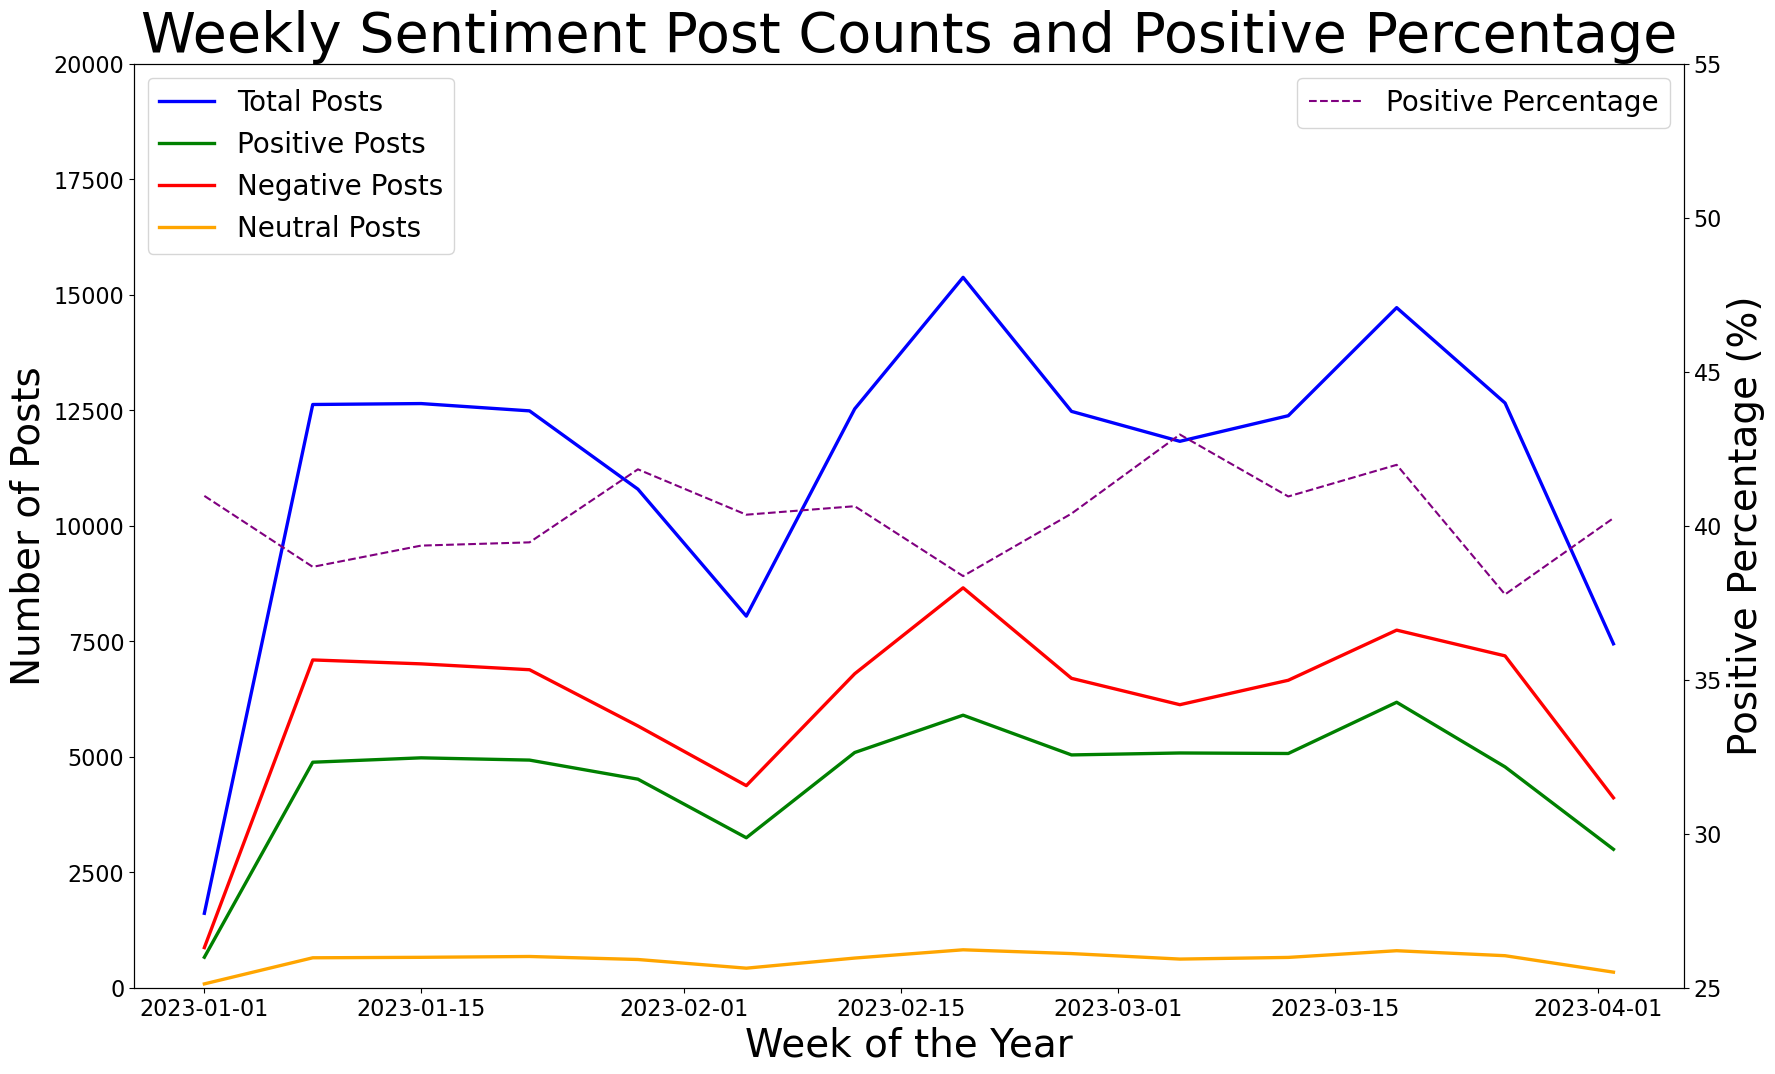

In [127]:
fig, ax1 = plt.subplots(figsize=(20, 12))

ax1.plot(weekly_data['week'], weekly_data['total_posts'], label='Total Posts', color='blue', linewidth=2.4)
ax1.plot(weekly_data['week'], weekly_data['positive'], label='Positive Posts', color='green', linewidth=2.4)
ax1.plot(weekly_data['week'], weekly_data['negative'], label='Negative Posts', color='red', linewidth=2.4)
ax1.plot(weekly_data['week'], weekly_data['neutral'], label='Neutral Posts', color='orange', linewidth=2.4)

ax1.set_xlabel('Week of the Year', fontsize=28)
ax1.set_ylabel('Number of Posts', fontsize=28)
ax1.set_title('Weekly Sentiment Post Counts and Positive Percentage', fontsize=40)
ax1.set_ylim(0, 20000)

# Create a second y-axis about the positive percentage
ax2 = ax1.twinx()
ax2.plot(weekly_data['week'], weekly_data['positive_percentage(%)'], label='Positive Percentage', color='purple', linestyle='--')
ax2.set_ylabel('Positive Percentage (%)', fontsize=28)
ax2.set_ylim(25, 55)

ax1.legend(fontsize=20, loc='upper left')
ax2.legend(fontsize=20, loc='upper right')
ax1.tick_params(axis='both', labelsize=16)
ax2.tick_params(axis='both', labelsize=16)


plt.savefig(f'{datapath}/plots/worldcup_weekly_sentiment_post_counts.png')
plt.show()


Summary: 

This NLP analysis suggests that of all the sub-topics about the World Cup 2022, people discussed the players most frequently. Additionally, a large amount of people might not be satisfied with certain judgments from the referees during the World Cup. It is also noticeable that people's general attitude towards the World Cup 2022 did not change much over time.